In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [2]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [4]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [5]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield x, y

In [7]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [9]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [10]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [11]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    
    mul = 4
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.Conv1D(
        filters=filters * mul,
        kernel_size=3,
        strides=1,
        padding="same"
    )(y)
    y = layers.GlobalAveragePooling1D()(y)
    
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [12]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [30]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1, epsilon=0.0001, wait=3):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        self.epsilon=epsilon
        self.wait=wait
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.wait_count=None
        self.prev_loss=None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0.0
        self.d_loss = 0.0
        self.d_iterations = 0.0
        self.d_iterations2 = 0.0
        self.d_1 = 0.0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.wait_count=0
        self.prev_loss=None
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        
        if self.prev_loss is None:
            self.prev_loss = logs["val_loss"]
        elif abs(self.prev_loss - logs["val_loss"]) < self.epsilon:
            self.wait_count += 1
        else:
            self.wait_count = 0
        self.prev_loss = logs["val_loss"]
        print(f"Wait to stop: {self.wait - self.wait_count}\n")
        if self.wait == self.wait_count:
            self.model.stop_training = True
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [24]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr =  3.8e-04
    
    steps = 100000
    steps_per_epoch = 1000
    epochs = steps // steps_per_epoch
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [22]:
FOLDS = 10

def train_oof(train_set, test_set, units=16):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {2 * np.std(scores) / len(scores) ** 2:0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          832       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          12352 

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3460 - val_loss: -0.3027

Epoch 00001: val_loss improved from inf to -0.30271, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0993
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4034 - val_loss: -0.4108

Epoch 00002: val_loss improved from -0.30271 to -0.41082, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0555
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4375 - val_loss: -0.4697

Epoch 00003: val_loss improved from -0.41082 to -0.46968, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0326
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4423 - val_loss: -0.4086

Epoch 00004: val_loss did not improve from -0.46968
Learning rate: 3.8e-04
Speed per epoch: -0.0241
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5706 - val_loss: -0.5635

Epoch 00035: val_loss improved from -0.56277 to -0.56351, saving model to ../processed/model.h5
Learning rate: 6.0e-06
Speed per epoch: -0.0034
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5740 - val_loss: -0.5633

Epoch 00036: val_loss did not improve from -0.56351
Learning rate: 4.6e-06
Speed per epoch: -0.0044
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5751 - val_loss: -0.5639

Epoch 00037: val_loss improved from -0.56351 to -0.56395, saving model to ../processed/model.h5
Learning rate: 4.2e-06
Speed per epoch: -0.0036
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5823 - val_loss: -0.5605

Epoch 00038: val_loss did not improve from -0.56395
Learning rate: 4.2e-06
Speed per epoch: -0.0011
Wait to stop: 3

Epoch 39/100
1000/1000 [=====

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3134 - val_loss: -0.3200

Epoch 00001: val_loss improved from inf to -0.32005, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.2416
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3983 - val_loss: -0.4239

Epoch 00002: val_loss improved from -0.32005 to -0.42390, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0753
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4232 - val_loss: -0.4649

Epoch 00003: val_loss improved from -0.42390 to -0.46492, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0316
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4392 - val_loss: -0.4596

Epoch 00004: val_loss did not improve from -0.46492
Learning rate: 3.8e-04
Speed per epoch: -0.0203
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5746 - val_loss: -0.5536

Epoch 00035: val_loss did not improve from -0.55516
Learning rate: 1.1e-05
Speed per epoch: -0.0059
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5779 - val_loss: -0.5552

Epoch 00036: val_loss improved from -0.55516 to -0.55522, saving model to ../processed/model.h5
Learning rate: 1.1e-05
Speed per epoch: -0.0029
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5699 - val_loss: -0.5551

Epoch 00037: val_loss did not improve from -0.55522
Learning rate: 7.0e-06
Speed per epoch: 0.0011
Wait to stop: 2

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5807 - val_loss: -0.5536

Epoch 00038: val_loss did not improve from -0.55522
Learning rate: 5.8e-06
Speed per epoch: -0.0028
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - lo

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3452 - val_loss: -0.3574

Epoch 00001: val_loss improved from inf to -0.35739, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1013
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3955 - val_loss: -0.4119

Epoch 00002: val_loss improved from -0.35739 to -0.41192, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0564
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4188 - val_loss: -0.4243

Epoch 00003: val_loss improved from -0.41192 to -0.42425, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0298
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4407 - val_loss: -0.4523

Epoch 00004: val_loss improved from -0.42425 to -0.45233, saving model to ../processed/model.h5
Learning rate:

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5679 - val_loss: -0.5762

Epoch 00035: val_loss improved from -0.57582 to -0.57623, saving model to ../processed/model.h5
Learning rate: 2.5e-06
Speed per epoch: -0.0004
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5734 - val_loss: -0.5763

Epoch 00036: val_loss improved from -0.57623 to -0.57626, saving model to ../processed/model.h5
Learning rate: 2.4e-06
Speed per epoch: -0.0007
Wait to stop: 2

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5664 - val_loss: -0.5776

Epoch 00037: val_loss improved from -0.57626 to -0.57757, saving model to ../processed/model.h5
Learning rate: 1.4e-06
Speed per epoch: 0.0014
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5758 - val_loss: -0.5786

Epoch 00038: val_loss improved from -0.57757 to -0.57855, saving model to ../processed/model.h5
Learnin

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3838 - val_loss: -0.3189

Epoch 00001: val_loss improved from inf to -0.31893, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0265
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4200 - val_loss: -0.3953

Epoch 00002: val_loss improved from -0.31893 to -0.39526, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0489
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4322 - val_loss: -0.4307

Epoch 00003: val_loss improved from -0.39526 to -0.43070, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0191
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4580 - val_loss: -0.4293

Epoch 00004: val_loss did not improve from -0.43070
Learning rate: 3.8e-04
Speed per epoch: -0.0222
Wait to st

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5624 - val_loss: -0.5309

Epoch 00035: val_loss did not improve from -0.53625
Learning rate: 1.3e-05
Speed per epoch: -0.0022
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5721 - val_loss: -0.5358

Epoch 00036: val_loss did not improve from -0.53625
Learning rate: 8.6e-06
Speed per epoch: -0.0056
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5737 - val_loss: -0.5290

Epoch 00037: val_loss did not improve from -0.53625
Learning rate: 8.5e-06
Speed per epoch: -0.0039
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5763 - val_loss: -0.5327

Epoch 00038: val_loss did not improve from -0.53625
Learning rate: 8.5e-06
Speed per epoch: -0.0016
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5813 - val_loss: -0.5321

Epoch 0003

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3533 - val_loss: -0.3561

Epoch 00001: val_loss improved from inf to -0.35607, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1230
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4124 - val_loss: -0.2850

Epoch 00002: val_loss did not improve from -0.35607
Learning rate: 3.8e-04
Speed per epoch: -0.0558
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4378 - val_loss: -0.4347

Epoch 00003: val_loss improved from -0.35607 to -0.43472, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0270
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4411 - val_loss: -0.4681

Epoch 00004: val_loss improved from -0.43472 to -0.46805, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0124
Wait to st

Learning rate: 4.4e-06
Speed per epoch: 0.0007
Wait to stop: 3

Epoch 35/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5851 - val_loss: -0.5619

Epoch 00035: val_loss improved from -0.56182 to -0.56193, saving model to ../processed/model.h5
Learning rate: 4.0e-06
Speed per epoch: -0.0089
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5825 - val_loss: -0.5632

Epoch 00036: val_loss improved from -0.56193 to -0.56320, saving model to ../processed/model.h5
Learning rate: 4.0e-06
Speed per epoch: -0.0049
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5689 - val_loss: -0.5640

Epoch 00037: val_loss improved from -0.56320 to -0.56405, saving model to ../processed/model.h5
Learning rate: 2.1e-06
Speed per epoch: 0.0034
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5775 - val_loss: -0.5632

Epoch 00038: val_loss did 

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3457 - val_loss: -0.3609

Epoch 00001: val_loss improved from inf to -0.36094, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1570
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4142 - val_loss: -0.4109

Epoch 00002: val_loss improved from -0.36094 to -0.41086, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0569
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4249 - val_loss: -0.4584

Epoch 00003: val_loss improved from -0.41086 to -0.45843, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0288
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4489 - val_loss: -0.4316

Epoch 00004: val_loss did not improve from -0.45843
Learning rate: 3.8e-04
Speed per epoch: -0.0232
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5568 - val_loss: -0.5489

Epoch 00036: val_loss did not improve from -0.55314
Learning rate: 3.1e-05
Speed per epoch: 0.0000
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5644 - val_loss: -0.5645

Epoch 00037: val_loss improved from -0.55314 to -0.56455, saving model to ../processed/model.h5
Learning rate: 2.0e-05
Speed per epoch: -0.0019
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5630 - val_loss: -0.5593

Epoch 00038: val_loss did not improve from -0.56455
Learning rate: 1.7e-05
Speed per epoch: 0.0002
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5724 - val_loss: -0.5554

Epoch 00039: val_loss did not improve from -0.56455
Learning rate: 1.6e-05
Speed per epoch: -0.0050
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 5s 5ms/step - los

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3394 - val_loss: -0.3790

Epoch 00001: val_loss improved from inf to -0.37903, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1631
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4083 - val_loss: -0.3931

Epoch 00002: val_loss improved from -0.37903 to -0.39314, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0635
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4332 - val_loss: -0.4597

Epoch 00003: val_loss improved from -0.39314 to -0.45970, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0391
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4570 - val_loss: -0.3633

Epoch 00004: val_loss did not improve from -0.45970
Learning rate: 3.8e-04
Speed per epoch: -0.0234
Wait to st

1000/1000 [==============================] - 7s 7ms/step - loss: -0.5643 - val_loss: -0.5504

Epoch 00035: val_loss improved from -0.54926 to -0.55042, saving model to ../processed/model.h5
Learning rate: 2.1e-05
Speed per epoch: -0.0017
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5673 - val_loss: -0.5539

Epoch 00036: val_loss improved from -0.55042 to -0.55386, saving model to ../processed/model.h5
Learning rate: 1.6e-05
Speed per epoch: -0.0038
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5772 - val_loss: -0.5521

Epoch 00037: val_loss did not improve from -0.55386
Learning rate: 1.6e-05
Speed per epoch: -0.0050
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.5797 - val_loss: -0.5551

Epoch 00038: val_loss improved from -0.55386 to -0.55510, saving model to ../processed/model.h5
Learning rate: 1.6e-05
Speed per epoch: -0.0063
Wa

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 8s 8ms/step - loss: -0.3257 - val_loss: -0.3257

Epoch 00001: val_loss improved from inf to -0.32573, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.2314
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.3982 - val_loss: -0.4236

Epoch 00002: val_loss improved from -0.32573 to -0.42361, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0728
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: -0.4162 - val_loss: -0.4095

Epoch 00003: val_loss did not improve from -0.42361
Learning rate: 3.8e-04
Speed per epoch: -0.0318
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 8s 8ms/step - loss: -0.4252 - val_loss: -0.4262

Epoch 00004: val_loss improved from -0.42361 to -0.42619, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0192
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5690 - val_loss: -0.5518

Epoch 00035: val_loss did not improve from -0.55587
Learning rate: 3.2e-05
Speed per epoch: -0.0055
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5660 - val_loss: -0.5468

Epoch 00036: val_loss did not improve from -0.55587
Learning rate: 3.2e-05
Speed per epoch: -0.0034
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5687 - val_loss: -0.5513

Epoch 00037: val_loss did not improve from -0.55587
Learning rate: 3.2e-05
Speed per epoch: -0.0020
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5673 - val_loss: -0.5506

Epoch 00038: val_loss did not improve from -0.55587
Learning rate: 2.5e-05
Speed per epoch: -0.0007
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5715 - val_loss: -0.5555

Epoch 0003

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3400 - val_loss: -0.4342

Epoch 00001: val_loss improved from inf to -0.43424, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1216
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4101 - val_loss: -0.4082

Epoch 00002: val_loss did not improve from -0.43424
Learning rate: 3.8e-04
Speed per epoch: -0.0678
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4263 - val_loss: -0.4243

Epoch 00003: val_loss did not improve from -0.43424
Learning rate: 3.8e-04
Speed per epoch: -0.0335
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4487 - val_loss: -0.4460

Epoch 00004: val_loss improved from -0.43424 to -0.44604, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0128
Wait to stop: 3

Epoch 5/100
1000/1000 [==============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5689 - val_loss: -0.5672

Epoch 00036: val_loss did not improve from -0.56740
Learning rate: 1.7e-05
Speed per epoch: -0.0038
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5695 - val_loss: -0.5612

Epoch 00037: val_loss did not improve from -0.56740
Learning rate: 1.7e-05
Speed per epoch: -0.0004
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5778 - val_loss: -0.5674

Epoch 00038: val_loss did not improve from -0.56740
Learning rate: 1.6e-05
Speed per epoch: -0.0032
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5797 - val_loss: -0.5681

Epoch 00039: val_loss improved from -0.56740 to -0.56808, saving model to ../processed/model.h5
Learning rate: 1.6e-05
Speed per epoch: -0.0021
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 5s 5ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3641 - val_loss: -0.3901

Epoch 00001: val_loss improved from inf to -0.39007, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.1539
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4091 - val_loss: -0.4189

Epoch 00002: val_loss improved from -0.39007 to -0.41895, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0417
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4210 - val_loss: -0.4182

Epoch 00003: val_loss did not improve from -0.41895
Learning rate: 3.8e-04
Speed per epoch: -0.0251
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4235 - val_loss: -0.4527

Epoch 00004: val_loss improved from -0.41895 to -0.45270, saving model to ../processed/model.h5
Learning rate: 3.8e-04
Speed per epoch: -0.0047
Wait to st

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5728 - val_loss: -0.5533

Epoch 00035: val_loss improved from -0.55012 to -0.55333, saving model to ../processed/model.h5
Learning rate: 2.6e-05
Speed per epoch: -0.0044
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5654 - val_loss: -0.5513

Epoch 00036: val_loss did not improve from -0.55333
Learning rate: 1.7e-05
Speed per epoch: -0.0010
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5705 - val_loss: -0.5447

Epoch 00037: val_loss did not improve from -0.55333
Learning rate: 1.5e-05
Speed per epoch: 0.0019
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5691 - val_loss: -0.5476

Epoch 00038: val_loss did not improve from -0.55333
Learning rate: 7.6e-06
Speed per epoch: 0.0003
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - los

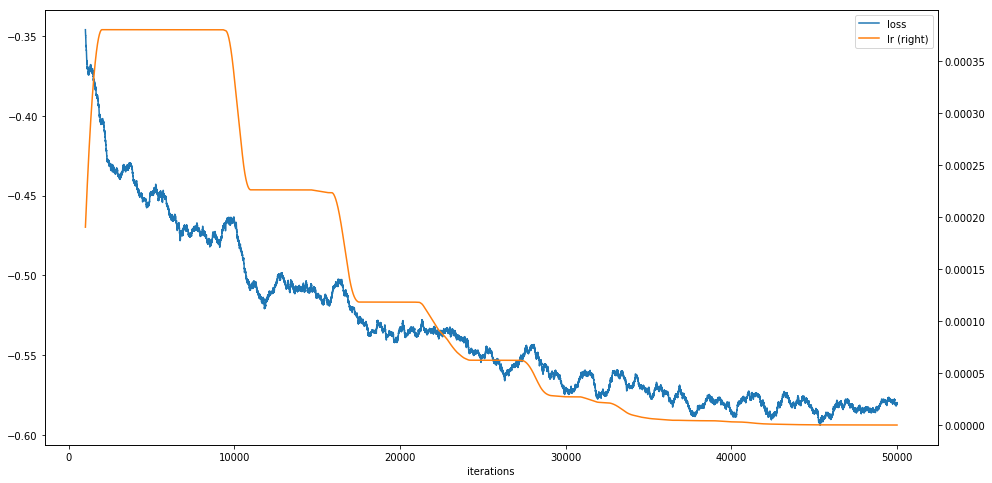

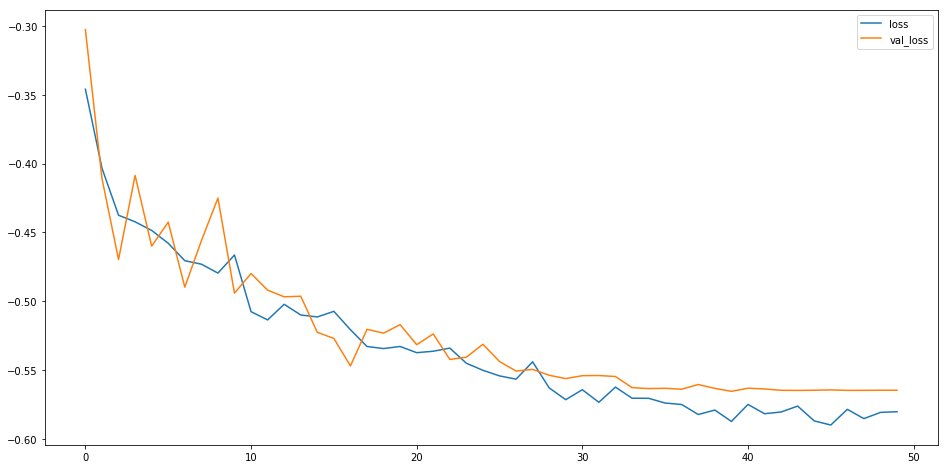

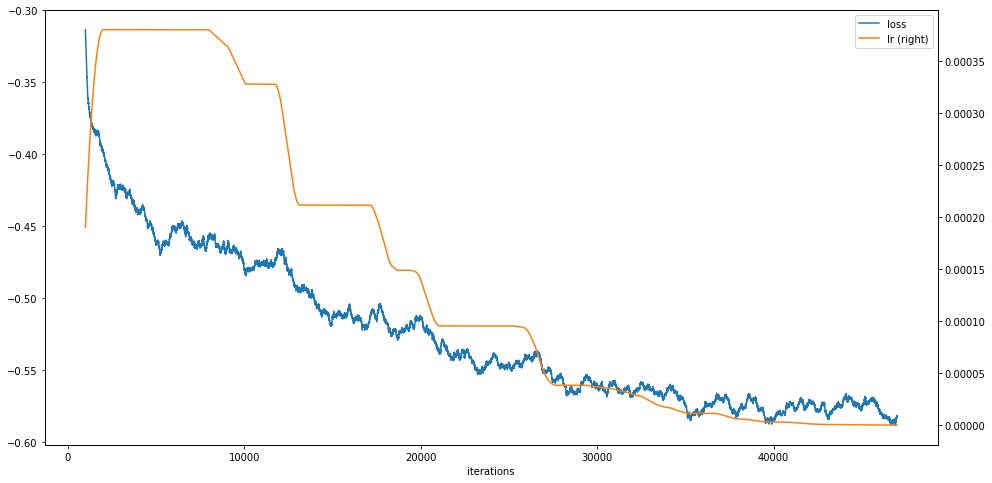

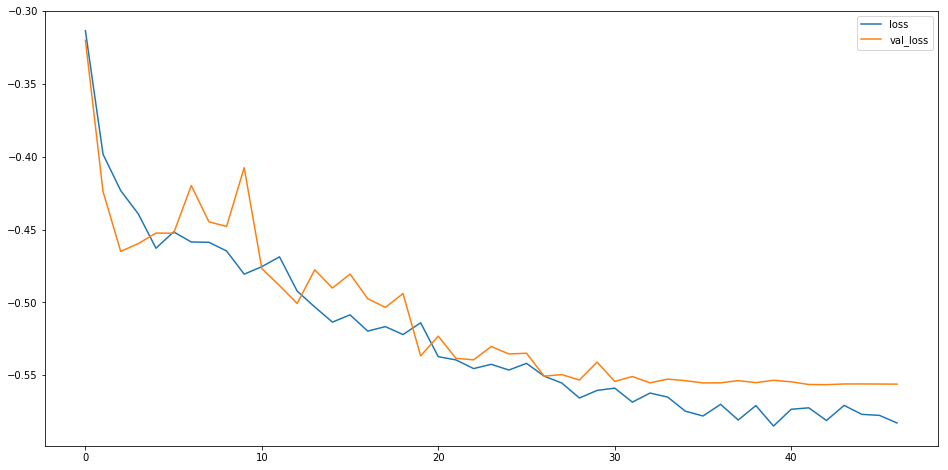

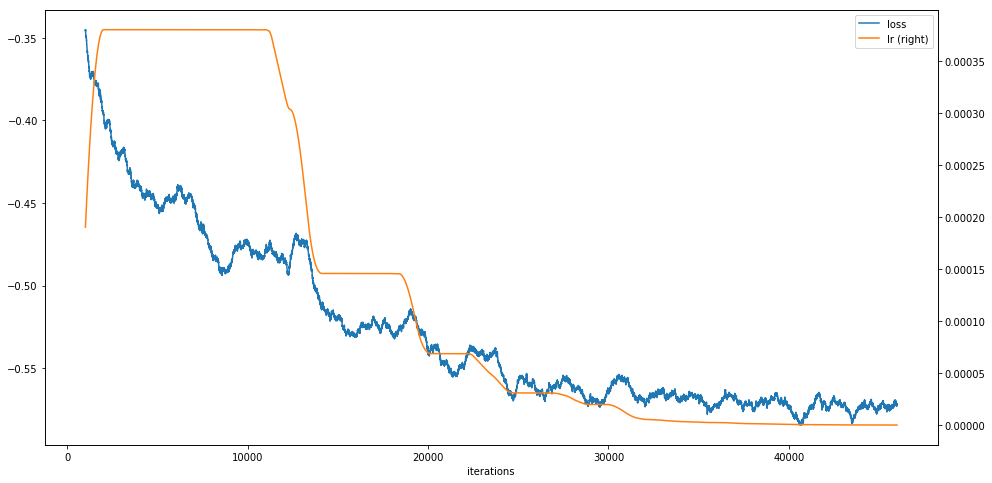

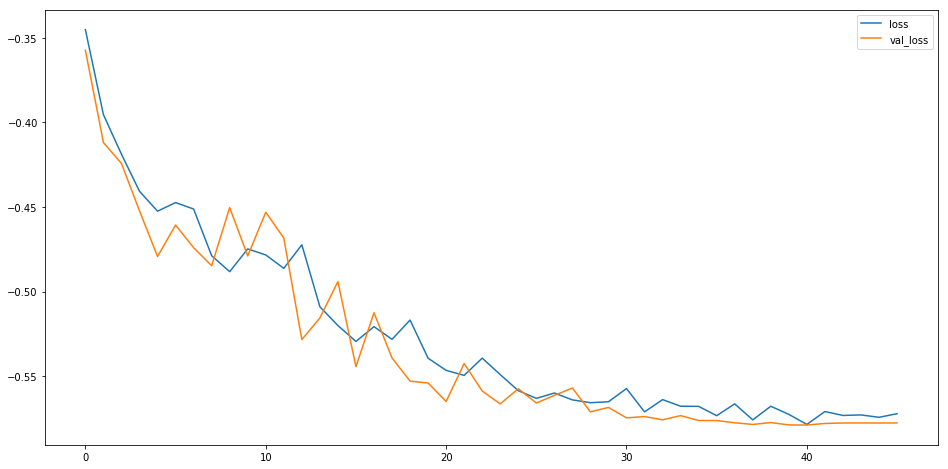

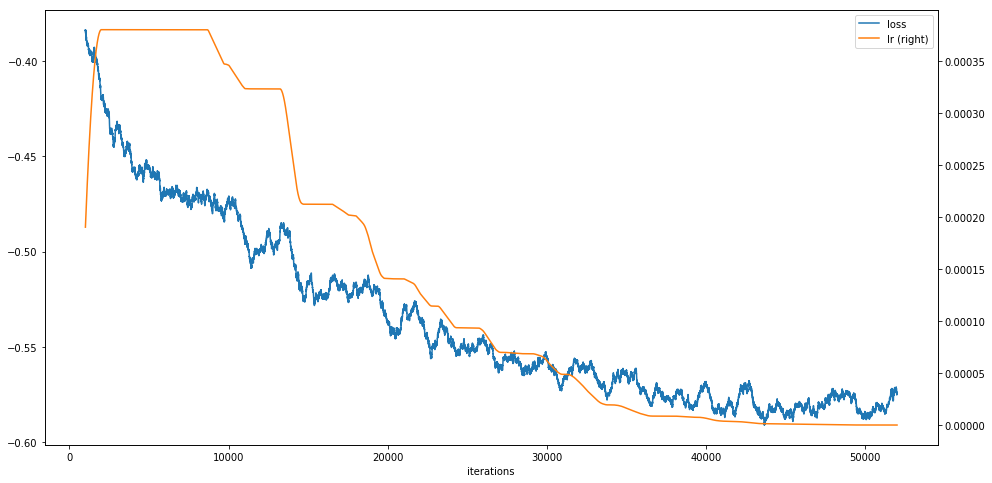

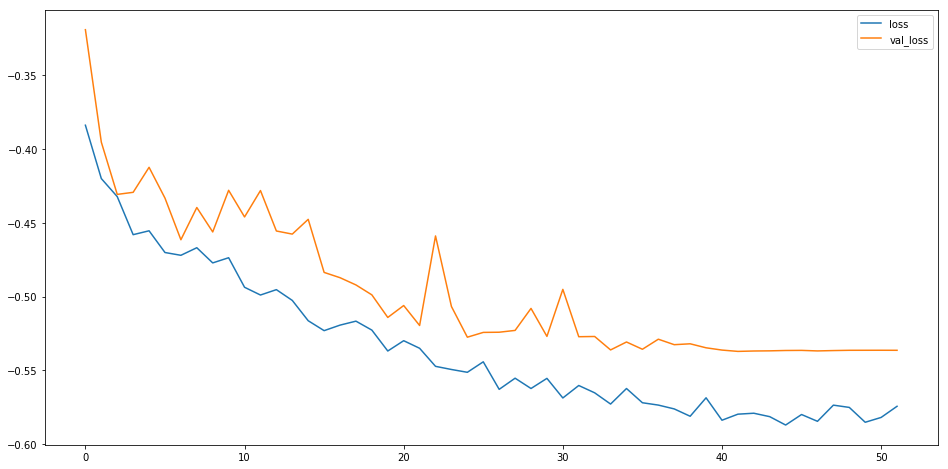

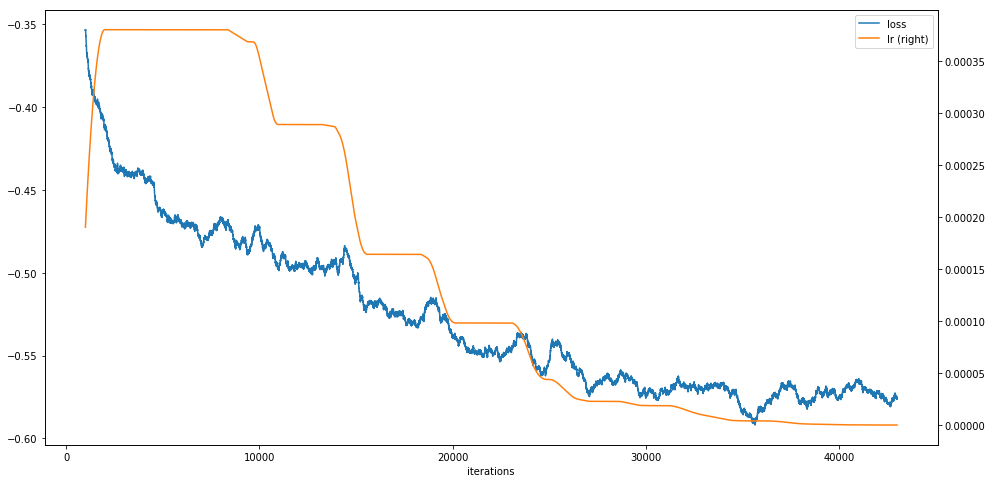

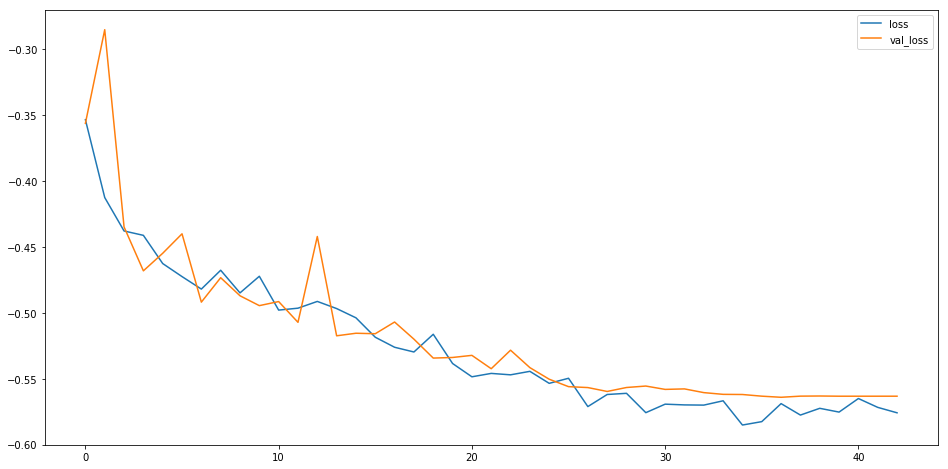

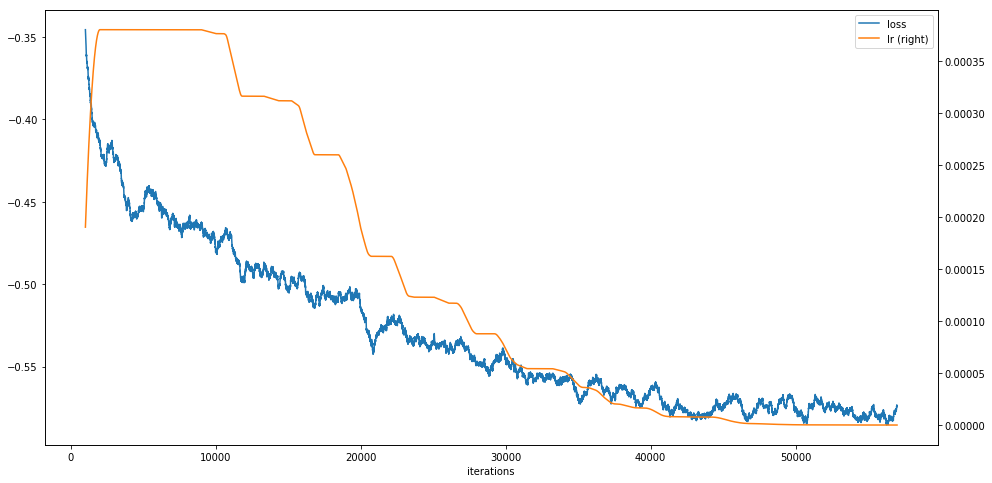

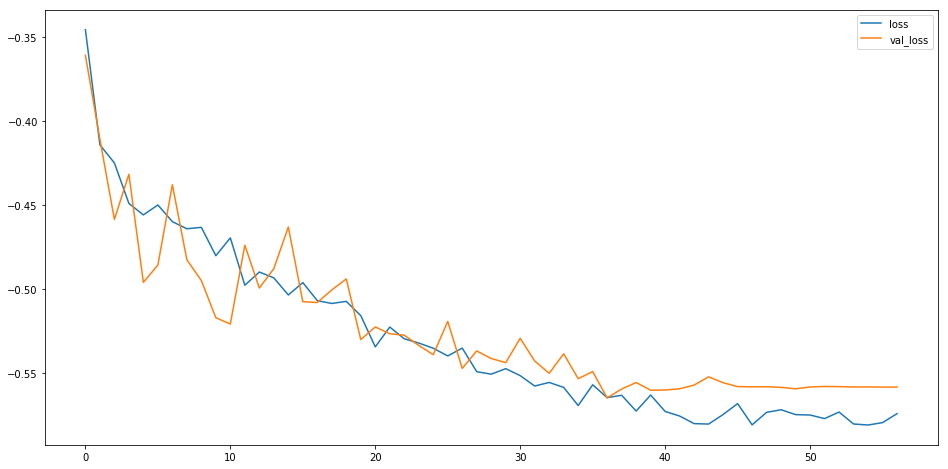

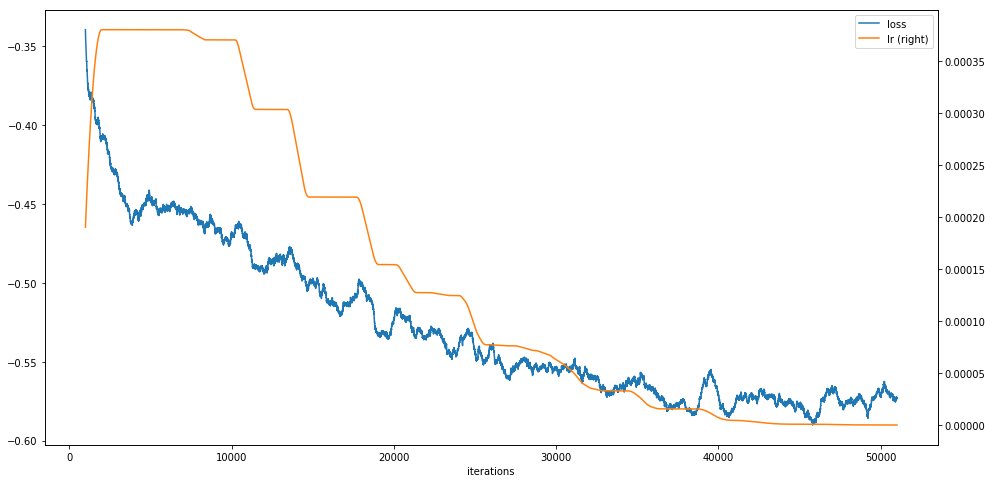

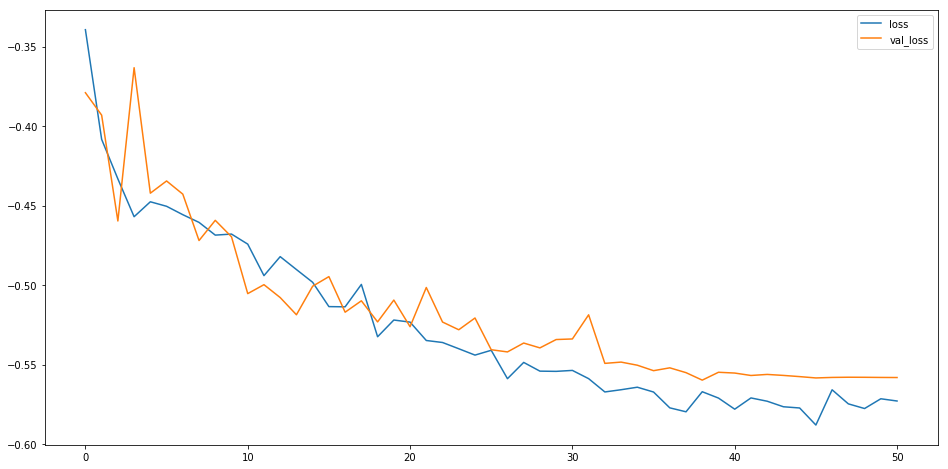

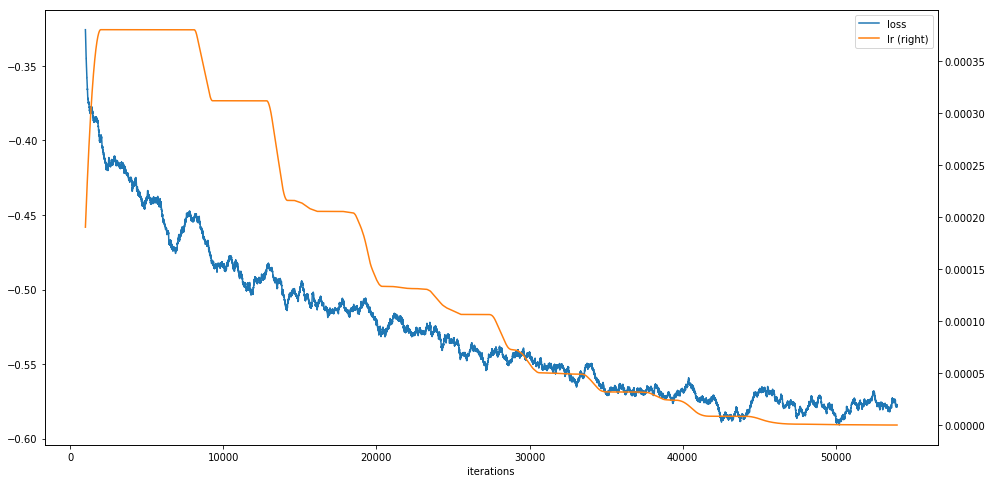

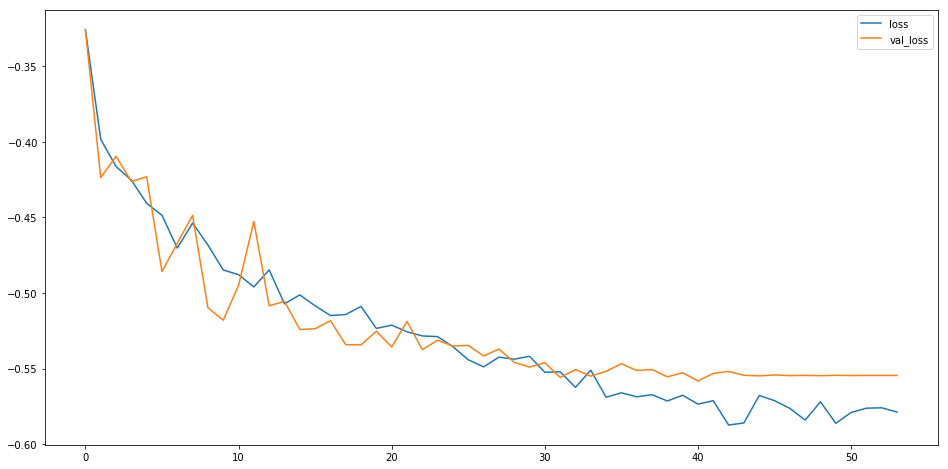

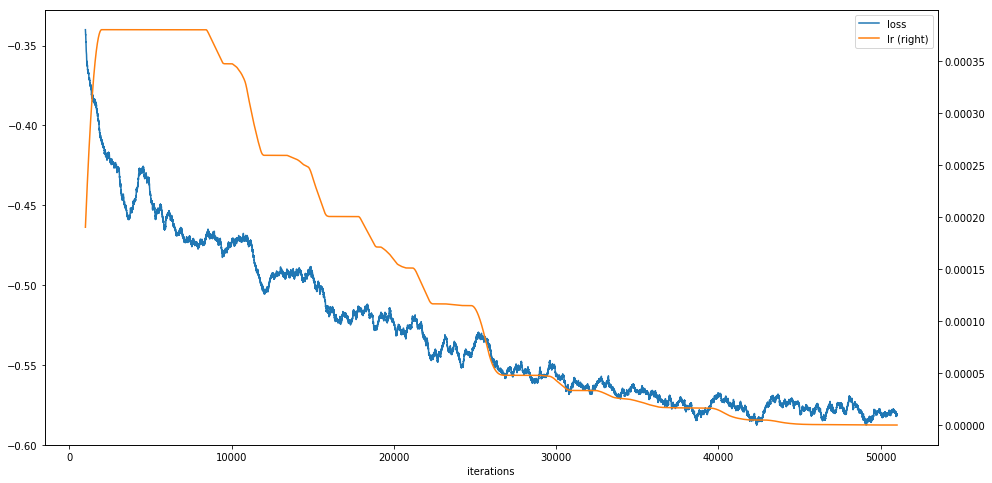

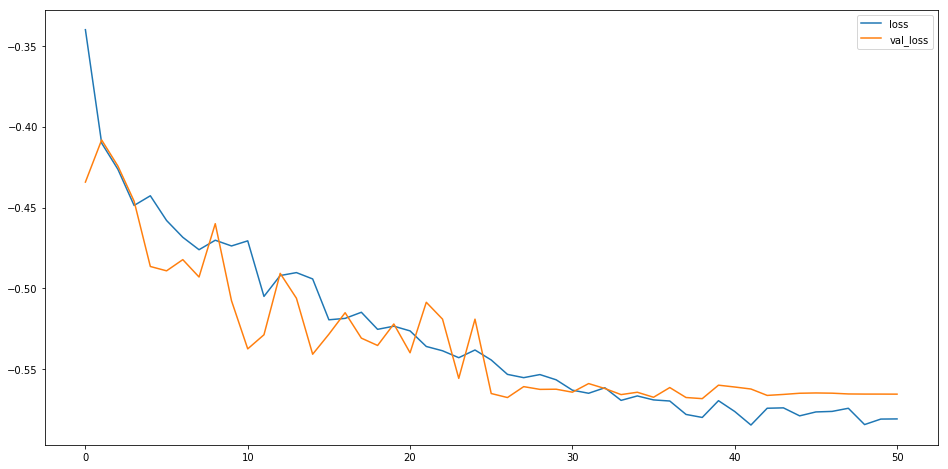

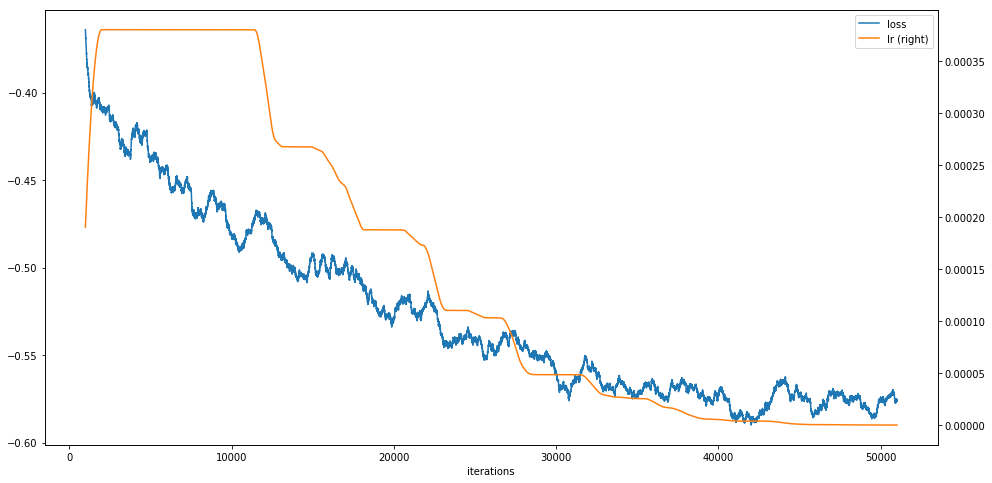

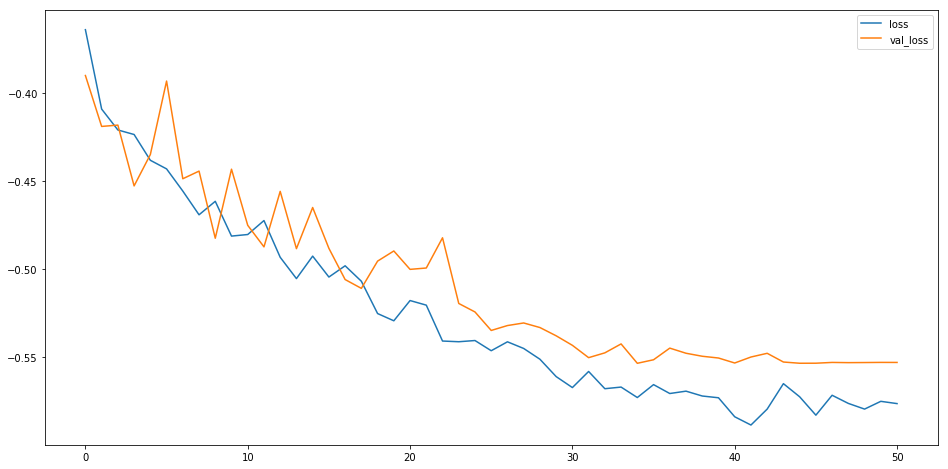

In [31]:
train_oof((votes, answers), votes_test)